In [1]:
from IPython.display import Image

PATH = "https://raw.githubusercontent.com/SIIIKOR/sad2/main/projekt2/"
IMG_PATH = PATH + "/BN.png"
TASK_1_IMG_PATH = PATH + "/TASK_1.jpg"
TASK_9_IMG_PATH = PATH + "/TASK_9.jpg"
Image(url=IMG_PATH)

In [2]:
from random import choices, random
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# **TASK 1**

In [3]:
Image(url=TASK_1_IMG_PATH, width=3200//3, height=1809//3)

In [4]:
P_ONE = 0.444               # P(C=T | R=T, S=T, W=T)
P_TWO = 0.048               # P(C=T | R=F, S=T, W=T)
P_THREE = 0.815             # P(R=T | C=T, S=T, W=T)
P_FOUR = 0.216              # P(R=T | C=F, S=T, W=T)

CLOUDY_DIST = (
    #C=FALSE    C=TRUE
    (1-P_TWO,   P_TWO),     #R=FALSE
    (1-P_ONE,   P_ONE)      #R=TRUE
)
RAIN_DIST = (
    #R=FALSE    R=TRUE
    (1-P_FOUR,  P_FOUR),    #C=FALSE
    (1-P_THREE, P_THREE)    #C=TRUE
)

DISTS = (CLOUDY_DIST, RAIN_DIST)

CHOICES = (0, 1)

# **TASK 2**

In [5]:
def gibbs_sample(n):
    samples = np.empty((n, 2), dtype=int)
    samples[0, 0] = 0                                                           # cloudy
    samples[0, 1] = 1                                                           # rain

    for i in range(1, n):                                                       # for each time step excluding first - initial values
        idx_var = int(random() > 0.5)                                           # Randomly select index of the first variable to sample
        idx_other_var = 1 - idx_var                                             # Index of the other variable

        x_other_var_prev = samples[i-1, idx_other_var]                          # Value of the other variable in the previous iteration
        x_var = choices(CHOICES, weights=DISTS[idx_var][idx_other_var])[0]      # Sample chosen variable value conditioning on the value of the other variable in the previous iteration
        x_other_var = choices(CHOICES, weights=DISTS[idx_other_var][x_var])[0]  # Sample other variable value conditioning on the samples value of the chosen variable
        
        samples[i, idx_var] = x_var
        samples[i, idx_other_var] = x_other_var

    return samples

# **TASK 3**

In [6]:
samples = gibbs_sample(100)

print("P(R=T|S=T,W=T) =", samples[:, 1].mean())

P(R=T|S=T,W=T) = 0.32


# **TASK 4**

In [7]:
samples_one = gibbs_sample(50_000)
samples_two = gibbs_sample(50_000)

# **TASK 5**

In [8]:
def get_zero_count(ones_count, idx):
    return (idx+1) - ones_count

def full_time_relative_counts(samples):
    counts = np.empty((len(samples), 2), dtype=int) #cloudy rain one counts
    counts[0, 0] = 0                                # initial values
    counts[0, 1] = 0

    for i, (x_cloudy, x_rain) in enumerate(samples):
        x_cloudy_freq = counts[i-1, 0] + x_cloudy if i != 0 else x_cloudy
        x_rain_freq = counts[i-1, 1] + x_rain if i != 0 else x_rain
        counts[i, 0] = x_cloudy_freq
        counts[i, 1] = x_rain_freq

    return counts

def counts_to_rf(samples):
    rf = np.empty((len(samples), 2), dtype=float)
    for i, val in enumerate(samples):
        rf[i] = val / i if i != 0 else val
    return rf

def plot_freqs(samples):
    fig, axs = plt.subplots(2, figsize=(12, 6))
    x = np.arange(len(samples))

    axs[0].plot(x, samples[:, 0])
    axs[0].set_ylabel("cloudy ones rf")
    axs[1].plot(x, samples[:, 1])
    axs[1].set_xlabel('t')
    axs[1].set_ylabel("rain ones rf")

    fig.show()

samples_one_rf = counts_to_rf(full_time_relative_counts(samples_one))
samples_two_rf = counts_to_rf(full_time_relative_counts(samples_two))

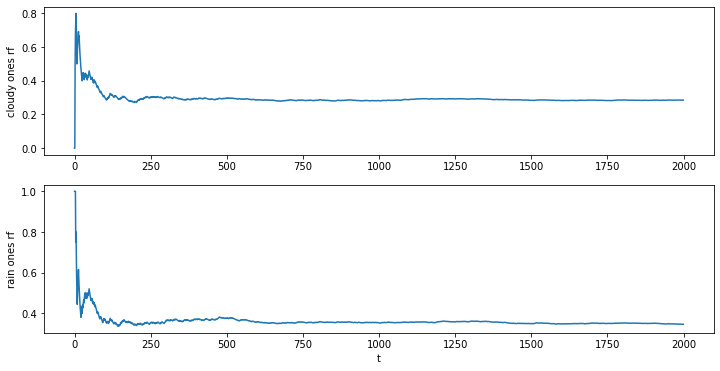

In [9]:
plot_freqs(samples_one_rf[:2000])

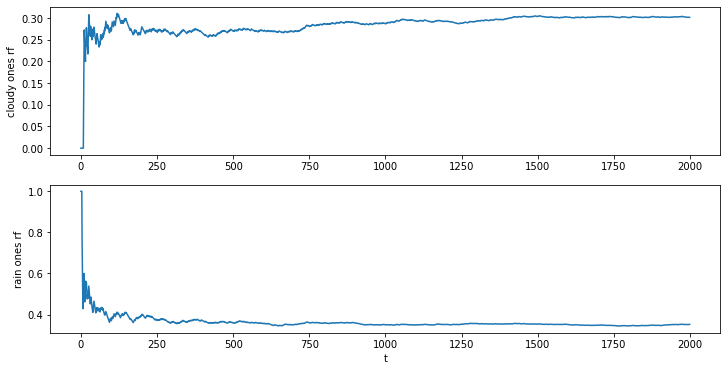

In [10]:
plot_freqs(samples_two_rf[:2000])

burn in time (takie najmniejsze t, że wykres zdaje się zbiegać) dla niektórych generacji może być tak małe jak t=100 a dla innych możę wymagać nawet t=400.

Mimo tego, że może wymagać tylko 400, czasem zdarza się tak, że po pewnym czasie wartości zaczynają w miare liniowo dośc powoli spadać lub wzrastać. W związku z tym decyduje się wziąć większe t, takie, po którym nie zauważe tych wzrostów lub spadków.

W związku z tym wydaje mi się, że w miare bezpieczny burn in time to t = 2000


# **TASK 6**

Zredukowałem ilość sampli do pokazania na wykresie, inaczej z wykresu nie jestem w stanie nic odczytać.

# **Cloudy**

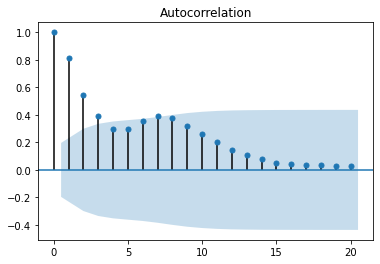

In [11]:
sm.graphics.tsa.plot_acf(samples_one_rf[:100, 0])
plt.show()

# **Rain**

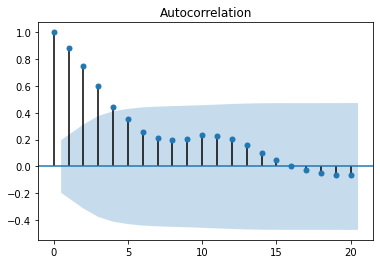

In [12]:
sm.graphics.tsa.plot_acf(samples_one_rf[:100, 1])
plt.show()

Możemy zauważyć, że korelacja na początku jest dodatnia. W przypadku cloudy spada do zera po interval=10 natomiast w przyadku rain jest zerowa tak szybko jak już po interval=4 lub interval=5. Dalej dla większych wartości oscyluje wokół zera.

Wybrałbym interval=10 tak aby dla obu było ok.


# **TASK 7**

In [13]:
def gibbs_sample_optimised(n, burn_in=2000, interval=10):
    samples = np.empty((burn_in + interval*n, 2), dtype=int)                    # we will have to make interval times more calculations to get n samples
    samples[0, 0] = 0                                                           # cloudy
    samples[0, 1] = 1                                                           # rain

    for i in range(1, burn_in + n*interval):                                    # for each time step excluding first - initial values
        idx_var = int(random() > 0.5)                                           # Randomly select index of the first variable to sample
        idx_other_var = 1 - idx_var                                             # Index of the other variable

        x_other_var_prev = samples[i-1, idx_other_var]                          # Value of the other variable in the previous iteration
        x_var = choices(CHOICES, weights=DISTS[idx_var][idx_other_var])[0]      # Sample chosen variable value conditioning on the value of the other variable in the previous iteration
        x_other_var = choices(CHOICES, weights=DISTS[idx_other_var][x_var])[0]  # Sample other variable value conditioning on the samples value of the chosen variable
        
        samples[i, idx_var] = x_var
        samples[i, idx_other_var] = x_other_var

    return samples[burn_in::interval]                                           # take only interval'th element after initial burn in

# **TASK 8**

In [14]:
samples = gibbs_sample_optimised(100)

print("P(R=T|S=T,W=T) =", samples[:, 1].mean())

P(R=T|S=T,W=T) = 0.33


# **TEST**

In [15]:
var = 1
t = 100
T = 1000
base_version_samples = np.array([gibbs_sample(t)[:, var].mean() for _ in range(T)])
improved_version_samples = np.array([gibbs_sample_optimised(t)[:, var].mean() for _ in range(T)])

In [16]:
print("base gibbs mean: ", base_version_samples.mean())
print("improved gibbs mean: ", improved_version_samples.mean())
print()
print("base gibbs variance: ", base_version_samples.var())
print("improved gibbs variance: ", improved_version_samples.var())

base gibbs mean:  0.35996
improved gibbs mean:  0.34945

base gibbs variance:  0.0022059984
improved gibbs variance:  0.0022645975


W obu przypadkach mean jest prawie taki sam (powinien być identyczny).
Natomiast wersja z brun in i spłaszczaniem ma mniejszą wariancje, czyli ogólnie jej wyniki są bliżej rzeczywistej wartości niż w przypadku wersji bazowej.

Pokazuje to, że mój burn in i interval poprawiają jakość samplowania, ale nie jakoś szczególnie bardzo.

# **TASK 9**

In [17]:
Image(url=TASK_9_IMG_PATH, width=3200//3, height=1809//3)

Otrzymywane przeze mnie wyniki nie są identyczne, ale są bardzo zbliżone do 0.32

# **BONUS**

Bazując na https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2018/Convergence-Tests.pdf?fbclid=IwAR2SkO2-oWiUOiNJK5CbuSZXJs9YjP4qmxuYBxrZ7jY3gHXs9vLSHBfmHO8

In [34]:
def gelman_rubin_test(x):
    chain_amount = x.shape[0]
    sample_amount = x.shape[1]
    all_samples = chain_amount * sample_amount
    
    chain_means = x.mean(axis=0)
    mean = chain_means.mean()
    chain_vars = x.var(axis=0, ddof=1)

    B = sample_amount/(chain_amount-1) * np.sum((chain_means - mean)**2, axis=0)
    W = chain_vars.sum() / chain_amount

    V_hat = (sample_amount - 1) * W / sample_amount + (chain_amount+1) * B / all_samples
    R = np.sqrt(V_hat / W)
    return R

x = np.array([gibbs_sample_optimised(100)[:, 1] for _ in range(25)])
R = gelman_rubin_test(x)

print(R)

1.0217027610816247


Wartość R wychodzi praktycznie równa 1, co oznacza, że się udało.